![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [1]:
# Research notebook for random forest algorithm
# Adapted from Jansen 2020  
import warnings
warnings.filterwarnings('ignore')

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from talib import RSI, BBANDS, MACD, NATR, ATR, PPO 
from scipy.stats import spearmanr, norm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from AlgorithmImports import *
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import joblib

idx = pd.IndexSlice
qb = QuantBook()

In [18]:
YEARS = 2
DAYS_PER_YEAR = 252
symbols = {}
assets = ["SHY", "TLT", "SHV", "TLH", "EDV", "BIL",
          "SPTL", "TBT", "TMF", "TMV", "TBF", "VGSH", "VGIT",
          "VGLT", "SCHO", "SCHR", "SPTS", "GOVT", 'SPY']

for i in range(len(assets)):
    symbols[assets[i]] = qb.AddEquity(assets[i],Resolution.Minute).Symbol

qb.SetStartDate(2020, 1, 1)

# qb.AddUniverse(CoarseSelectionFunction, FineSelectionFunction)
df = qb.History(qb.Securities.Keys, YEARS*DAYS_PER_YEAR, resolution=Resolution.Daily) 
df.dropna(inplace=True)

df.head()

close       high        low       open  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2017-12-30  77.394975  77.413436  77.385745  77.385745   
                 2018-01-03  77.367285  77.385745  77.339594  77.376515   
                 2018-01-04  77.367285  77.385745  77.339594  77.358055   
                 2018-01-05  77.330364  77.348825  77.302674  77.321134   
                 2018-01-06  77.330364  77.339594  77.311904  77.321134   

                                volume  
symbol           time                   
SHY SGNKIKYGE9NP 2017-12-30  1311448.0  
                 2018-01-03  1933757.0  
                 2018-01-04  1127633.0  
                 2018-01-05  1035132.0  
                 2018-01-06   921423.0

### Create Features

In [19]:
# calculate returns
intervals = [1, 5, 10, 21, 63]
returns = []
by_symbol = df.groupby('symbol', group_keys=False)
for t in intervals:
    returns.append(by_symbol.close.pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)
df1 = df 
df = pd.merge(df1, returns, on=('symbol', 'time'))
returns.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9576 entries, ('SHY SGNKIKYGE9NP', Timestamp('2017-12-30 00:00:00')) to ('SPY R735QTJ8XC9X', Timestamp('2020-01-01 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ret_1   9557 non-null   float64
 1   ret_5   9481 non-null   float64
 2   ret_10  9386 non-null   float64
 3   ret_21  9177 non-null   float64
 4   ret_63  8379 non-null   float64
dtypes: float64(5)
memory usage: 423.0+ KB


close       high        low       open  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2017-12-30  77.394975  77.413436  77.385745  77.385745   
                 2018-01-03  77.367285  77.385745  77.339594  77.376515   
                 2018-01-04  77.367285  77.385745  77.339594  77.358055   
                 2018-01-05  77.330364  77.348825  77.302674  77.321134   
                 2018-01-06  77.330364  77.339594  77.311904  77.321134   

                                volume     ret_1  ret_5  ret_10  ret_21  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2017-12-30  1311448.0       NaN    NaN     NaN     NaN   
                 2018-01-03  1933757.0 -0.000358    NaN     NaN     NaN   
                 2018-01-04  1127633.0  0.000000    NaN     NaN     NaN   
                 2018-01-05  1035132.0 -0.000477    NaN     NaN     NaN   
                 2018-01-06   921423.0  0.000000    NaN     NaN     NaN   

                             ret_63  
symbol           time                
SHY SGNKIKYGE9NP 2017-12-30     NaN  
                 2018-01-03     NaN  
                 2018-01-04     NaN  
                 2018-01-05     NaN  
                 2018-01-06     NaN

In [20]:
by_symbol = df.groupby('symbol', group_keys=False)
df['rsi'] = df.groupby('symbol').close.apply(RSI)
df['ppo'] = df.groupby('symbol').close.apply(PPO)
df.head()

close       high        low       open  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2017-12-30  77.394975  77.413436  77.385745  77.385745   
                 2018-01-03  77.367285  77.385745  77.339594  77.376515   
                 2018-01-04  77.367285  77.385745  77.339594  77.358055   
                 2018-01-05  77.330364  77.348825  77.302674  77.321134   
                 2018-01-06  77.330364  77.339594  77.311904  77.321134   

                                volume     ret_1  ret_5  ret_10  ret_21  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2017-12-30  1311448.0       NaN    NaN     NaN     NaN   
                 2018-01-03  1933757.0 -0.000358    NaN     NaN     NaN   
                 2018-01-04  1127633.0  0.000000    NaN     NaN     NaN   
                 2018-01-05  1035132.0 -0.000477    NaN     NaN     NaN   
                 2018-01-06   921423.0  0.000000    NaN     NaN     NaN   

                             ret_63  rsi  ppo  
symbol           time                          
SHY SGNKIKYGE9NP 2017-12-30     NaN  NaN  NaN  
                 2018-01-03     NaN  NaN  NaN  
                 2018-01-04     NaN  NaN  NaN  
                 2018-01-05     NaN  NaN  NaN  
                 2018-01-06     NaN  NaN  NaN

In [21]:
# compute bollenger bands
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_mid': mid, 'bb_low': low}, index=close.index)
bb_df = df.groupby('symbol').close.apply(compute_bb)
bb_df.head() 

bb_high  bb_mid  bb_low
symbol           time                               
SHY SGNKIKYGE9NP 2017-12-30      NaN     NaN     NaN
                 2018-01-03      NaN     NaN     NaN
                 2018-01-04      NaN     NaN     NaN
                 2018-01-05      NaN     NaN     NaN
                 2018-01-06      NaN     NaN     NaN

In [22]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, stock_data.low, stock_data.close, timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())
# atr_series = by_symbol.apply(compute_atr)
df['atr'] =  by_symbol.apply(compute_atr)
df.head()

close       high        low       open  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2017-12-30  77.394975  77.413436  77.385745  77.385745   
                 2018-01-03  77.367285  77.385745  77.339594  77.376515   
                 2018-01-04  77.367285  77.385745  77.339594  77.358055   
                 2018-01-05  77.330364  77.348825  77.302674  77.321134   
                 2018-01-06  77.330364  77.339594  77.311904  77.321134   

                                volume     ret_1  ret_5  ret_10  ret_21  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2017-12-30  1311448.0       NaN    NaN     NaN     NaN   
                 2018-01-03  1933757.0 -0.000358    NaN     NaN     NaN   
                 2018-01-04  1127633.0  0.000000    NaN     NaN     NaN   
                 2018-01-05  1035132.0 -0.000477    NaN     NaN     NaN   
                 2018-01-06   921423.0  0.000000    NaN     NaN     NaN   

                             ret_63  rsi  ppo  atr  
symbol           time                               
SHY SGNKIKYGE9NP 2017-12-30     NaN  NaN  NaN  NaN  
                 2018-01-03     NaN  NaN  NaN  NaN  
                 2018-01-04     NaN  NaN  NaN  NaN  
                 2018-01-05     NaN  NaN  NaN  NaN  
                 2018-01-06     NaN  NaN  NaN  NaN

In [23]:

df['natr'] =  by_symbol.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

In [24]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

macd_series = df.groupby(level='symbol').close.apply(compute_macd)
df['macd'] = macd_series.to_frame().drop_duplicates() 

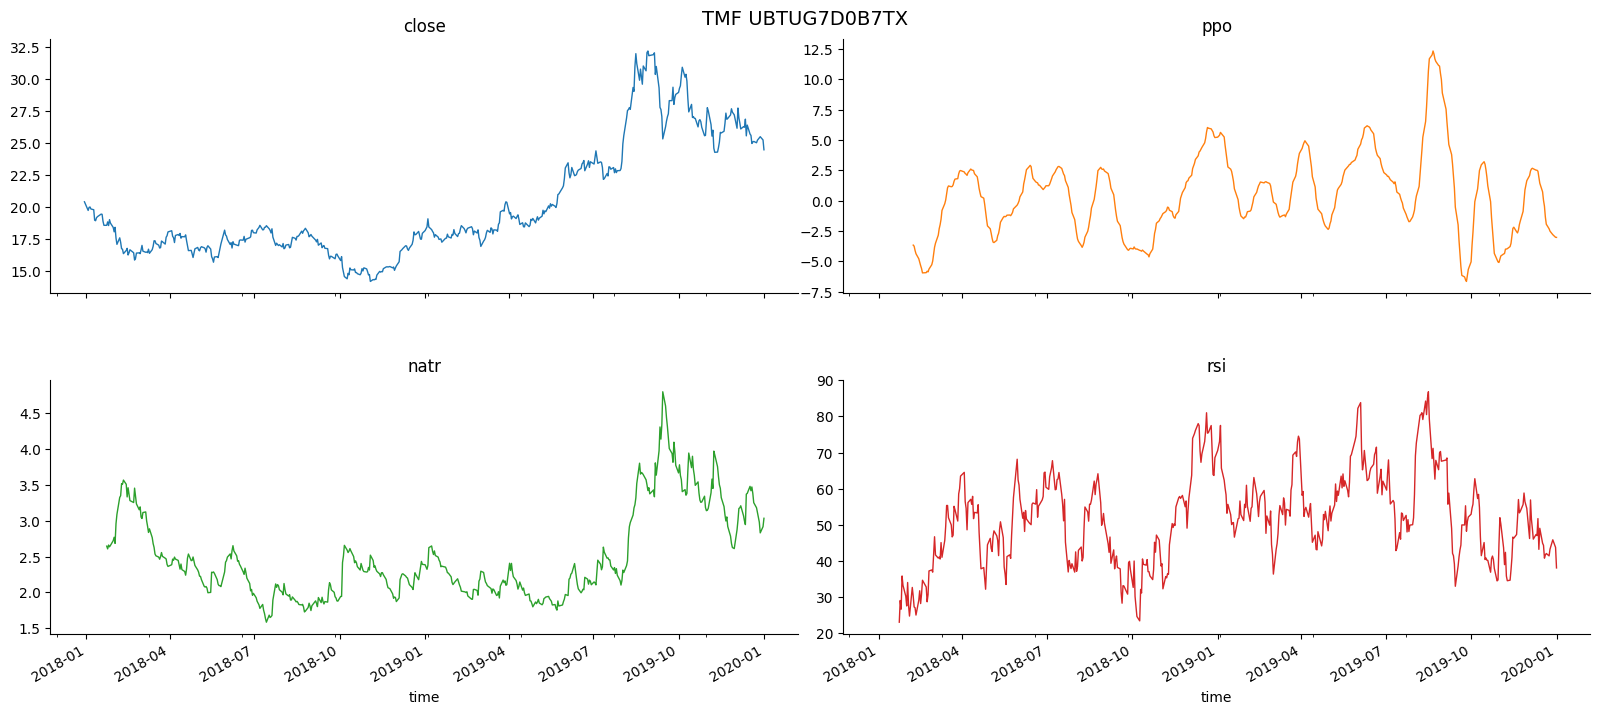

In [25]:
indicators = ['close', 'ppo', 'natr',  'rsi']
ticker = np.random.choice(df.index.get_level_values('symbol'))
(df.loc[idx[ticker, :], indicators].reset_index('symbol', drop=True)
 .plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.suptitle(ticker, fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.95)

In [26]:
outcomes = []
by_ticker = df.groupby('symbol')
for t in intervals:
    k = f'fwd_ret_{t}'
    outcomes.append(k)
    df[k] = by_ticker[f'ret_{t}'].shift(-t)
df.head(10)

close       high        low       open  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2017-12-30  77.394975  77.413436  77.385745  77.385745   
                 2018-01-03  77.367285  77.385745  77.339594  77.376515   
                 2018-01-04  77.367285  77.385745  77.339594  77.358055   
                 2018-01-05  77.330364  77.348825  77.302674  77.321134   
                 2018-01-06  77.330364  77.339594  77.311904  77.321134   
                 2018-01-09  77.330364  77.348825  77.311904  77.348825   
                 2018-01-10  77.302674  77.339594  77.302674  77.321134   
                 2018-01-11  77.330364  77.330364  77.284213  77.293444   
                 2018-01-12  77.302674  77.330364  77.302674  77.311904   
                 2018-01-13  77.293444  77.302674  77.274983  77.284213   

                                volume     ret_1     ret_5  ret_10  ret_21  \
symbol           time                                                        
SHY SGNKIKYGE9NP 2017-12-30  1311448.0       NaN       NaN     NaN     NaN   
                 2018-01-03  1933757.0 -0.000358       NaN     NaN     NaN   
                 2018-01-04  1127633.0  0.000000       NaN     NaN     NaN   
                 2018-01-05  1035132.0 -0.000477       NaN     NaN     NaN   
                 2018-01-06   921423.0  0.000000       NaN     NaN     NaN   
                 2018-01-09   647521.0  0.000000 -0.000835     NaN     NaN   
                 2018-01-10  1681315.0 -0.000358 -0.000835     NaN     NaN   
                 2018-01-11   854755.0  0.000358 -0.000477     NaN     NaN   
                 2018-01-12  1134728.0 -0.000358 -0.000358     NaN     NaN   
                 2018-01-13   979566.0 -0.000119 -0.000477     NaN     NaN   

                             ret_63  rsi  ppo  atr  natr  macd  fwd_ret_1  \
symbol           time                                                       
SHY SGNKIKYGE9NP 2017-12-30     NaN  NaN  NaN  NaN   NaN   NaN  -0.000358   
                 2018-01-03     NaN  NaN  NaN  NaN   NaN   NaN   0.000000   
                 2018-01-04     NaN  NaN  NaN  NaN   NaN   NaN  -0.000477   
                 2018-01-05     NaN  NaN  NaN  NaN   NaN   NaN   0.000000   
                 2018-01-06     NaN  NaN  NaN  NaN   NaN   NaN   0.000000   
                 2018-01-09     NaN  NaN  NaN  NaN   NaN   NaN  -0.000358   
                 2018-01-10     NaN  NaN  NaN  NaN   NaN   NaN   0.000358   
                 2018-01-11     NaN  NaN  NaN  NaN   NaN   NaN  -0.000358   
                 2018-01-12     NaN  NaN  NaN  NaN   NaN   NaN  -0.000119   
                 2018-01-13     NaN  NaN  NaN  NaN   NaN   NaN  -0.000119   

                             fwd_ret_5  fwd_ret_10  fwd_ret_21  fwd_ret_63  
symbol           time                                                       
SHY SGNKIKYGE9NP 2017-12-30  -0.000835   -0.001431   -0.002862   -0.001583  
                 2018-01-03  -0.000835   -0.001432   -0.002909   -0.001824  
                 2018-01-04  -0.000477   -0.001670   -0.002790   -0.001585  
                 2018-01-05  -0.000358   -0.000836   -0.000521   -0.000270  
                 2018-01-06  -0.000477   -0.001313   -0.001238   -0.000390  
                 2018-01-09  -0.000597   -0.000716   -0.001955   -0.000869  
                 2018-01-10  -0.000597   -0.000597   -0.001478   -0.000511  
                 2018-01-11  -0.001194   -0.001194   -0.000999   -0.001467  
                 2018-01-12  -0.000478   -0.001433   -0.001120   -0.001349  
                 2018-01-13  -0.000836   -0.001672   -0.001000   -0.001350

### Training Model

In [27]:
from ml_utils import *
n_splits = 30
train_period_length = 60
test_period_length = 6
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

In [12]:
for i, (train_idx, test_idx) in enumerate(cv.split(X=df)):
    train = df.iloc[train_idx]
    train_times = train.index.get_level_values('time')
    test = df.iloc[test_idx]
    test_times = test.index.get_level_values('time')
    df1 = train.reset_index().append(test.reset_index())
    n = len(df1)
    assert n== len(df1.drop_duplicates())
    msg = f'Training: {train_times.min().date()}-{train_times.max().date()} '
    msg += f' ({train.groupby(level="symbol").size().value_counts().index[0]:,.0f} days) | '
    msg += f'Test: {test_times.min().time()}-{test_times.max().date()} '
    msg += f'({test.groupby(level="symbol").size().value_counts().index[0]:,.0f} days)'
    print(msg)
    #if i == 3:
        # break

Training: 2019-09-28-2019-12-21  (60 days) | Test: 00:00:00-2020-01-01 (6 days)
Training: 2019-09-20-2019-12-13  (60 days) | Test: 00:00:00-2019-12-21 (6 days)
Training: 2019-09-12-2019-12-05  (60 days) | Test: 00:00:00-2019-12-13 (6 days)
Training: 2019-09-04-2019-11-26  (60 days) | Test: 00:00:00-2019-12-05 (6 days)
Training: 2019-08-24-2019-11-16  (60 days) | Test: 00:00:00-2019-11-26 (6 days)
Training: 2019-08-16-2019-11-08  (60 days) | Test: 00:00:00-2019-11-16 (6 days)
Training: 2019-08-08-2019-10-31  (60 days) | Test: 00:00:00-2019-11-08 (6 days)
Training: 2019-07-31-2019-10-23  (60 days) | Test: 00:00:00-2019-10-31 (6 days)
Training: 2019-07-23-2019-10-15  (60 days) | Test: 00:00:00-2019-10-23 (6 days)
Training: 2019-07-13-2019-10-05  (60 days) | Test: 00:00:00-2019-10-15 (6 days)
Training: 2019-07-04-2019-09-27  (60 days) | Test: 00:00:00-2019-10-05 (6 days)
Training: 2019-06-26-2019-09-19  (60 days) | Test: 00:00:00-2019-09-27 (6 days)
Training: 2019-06-18-2019-09-11  (60 day

In [28]:
rf_reg = RandomForestRegressor(n_estimators=100, 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=5, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False)

In [43]:
df.dropna(inplace=True)
target = sorted(df.filter(like='fwd').columns)
features = df.columns.difference(target).tolist()

X = df.drop(target, axis=1)
y = df.fwd_ret_1.to_frame()
X.head()
y.head()  

latest = df.time.groupby('symbol', group_keys=False).max() 
latest

# rf_reg.fit(X, y)


AttributeError: 'DataFrame' object has no attribute 'time'

In [41]:
rf_reg.predict(X[-1:])

array([-0.0093475])

In [ ]:

def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0]

ic = make_scorer(rank_correl)
cv_score = cross_val_score(estimator=rf_reg,
                           X=X,
                           y=y,
                           scoring=ic,
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)


In [ ]:
print(np.mean(cv_score))


In [ ]:
param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [5, 25, 100]}
gridsearch_reg = GridSearchCV(estimator=rf_reg,
                      param_grid=param_grid,
                      scoring=ic,
                      n_jobs=-1,
                      cv=cv,
                      refit=True,
                      return_train_score=True,
                      verbose=1)

In [ ]:
gs_reg = gridsearch_reg
gridsearch_reg.fit(X=X, y=y)

In [ ]:
gridsearch_reg.best_params_